In [139]:
!pip install librosa soundfile numpy scikit-learn tensorflow matplotlib pandas


In [141]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import pickle
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics


In [142]:
data_directory = "C:/Users/ARNAV_MISHRA/OneDrive/Desktop/SpeechProject/DataBase"

In [143]:
# Emotions in the RAVDESS dataset, different numbers represent different emotion
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

In [211]:
def extract_feature(data, sr, mfcc=True, chroma=True, mel=True):
    """
    Extract features from audio files into numpy array

    Parameters:
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient
    chroma : boolean, Chroma feature
    mel : boolean, Mel Spectrogram Frequency
    """
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        stft = np.abs(librosa.stft(data))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
        result = np.hstack((result, mel))
        
    return result


In [145]:
def noise(data, noise_factor=0.001):
    """
    Add random white noises to the audio

    Parameters:
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, measure of noise to be added
    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [146]:
def shift(data, sampling_rate, shift_max=0.25, shift_direction='right'):
    """
    Shift the spectrogram in a direction

    Parameters:
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, 'right' or 'both'
    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
        
    return augmented_data

In [147]:
def load_data(save=False):
    """
    Load dataset and optionally save as .npy files

    Parameters:
    ----------
    save : boolean, save the data to disk as .npy
    """
    x, y = [], []
    for file in glob.glob(os.path.join(data_directory, "Actor_*", "*.wav")):
        # Load an audio file as a floating point time series
        data, sr = librosa.load(file)
        
        # Extract features from original data
        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        
        # Get emotion label from the file name
        emotion = emotions[file.split("-")[2]]
        y.append(emotion)
        
        # Add noise to the data and extract features
        n_data = noise(data)
        n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)
        
        # Shift the data and extract features
        s_data = shift(data, sr)
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)
    
    x = np.array(x)
    if save:
        np.save('X.npy', x)
        np.save('y.npy', y)
    
    return x, y

In [148]:
# Load data
X, y = load_data(save=True)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)


In [151]:
# Label encoding
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

# Print label mapping
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print("Label Mapping:")
print(le_name_mapping)

Label Mapping:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}


In [152]:
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [153]:
#ADDING THE MODEL(CNN)
#MODEL TRAINING

from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv1D(256, 5, padding='same', input_shape=(180, 1)))
model.add(Activation('relu'))

# 2nd Convolutional Layer
model.add(Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Activation('relu'))
model.add(Dropout(0.1))

# Max Pooling
model.add(MaxPooling1D(pool_size=(8)))

# 3rd Convolutional Layer
model.add(Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Flatten the output
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(units=8, 
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)))
model.add(Activation('softmax'))

# Compile the model with Adam optimizer
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 180, 256)          1536      
                                                                 
 activation_30 (Activation)  (None, 180, 256)          0         
                                                                 
 conv1d_25 (Conv1D)          (None, 180, 128)          163968    
                                                                 
 activation_31 (Activation)  (None, 180, 128)          0         
                                                                 
 dropout_12 (Dropout)        (None, 180, 128)          0         
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 22, 128)           0         
 g1D)                                                            
                                                      

In [154]:
#STARTS TRAINING THE MODEL

XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)
history = model.fit(XProccessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test), batch_size=64)

Epoch 1/100
51/51 [==============================] - 16s 220ms/step - loss: 2.3339 - accuracy: 0.2281 - val_loss: 1.9161 - val_accuracy: 0.3259
Epoch 2/100
51/51 [==============================] - 11s 210ms/step - loss: 1.9157 - accuracy: 0.3170 - val_loss: 1.7691 - val_accuracy: 0.3954
Epoch 3/100
51/51 [==============================] - 11s 210ms/step - loss: 1.7794 - accuracy: 0.3719 - val_loss: 1.7094 - val_accuracy: 0.4037
Epoch 4/100
51/51 [==============================] - 11s 215ms/step - loss: 1.7233 - accuracy: 0.3954 - val_loss: 1.6158 - val_accuracy: 0.4667
Epoch 5/100
51/51 [==============================] - 10s 205ms/step - loss: 1.6205 - accuracy: 0.4383 - val_loss: 1.5286 - val_accuracy: 0.4944
Epoch 6/100
51/51 [==============================] - 11s 210ms/step - loss: 1.5329 - accuracy: 0.4756 - val_loss: 1.4660 - val_accuracy: 0.5167
Epoch 7/100
51/51 [==============================] - 11s 210ms/step - loss: 1.4687 - accuracy: 0.5003 - val_loss: 1.3937 - val_accuracy:

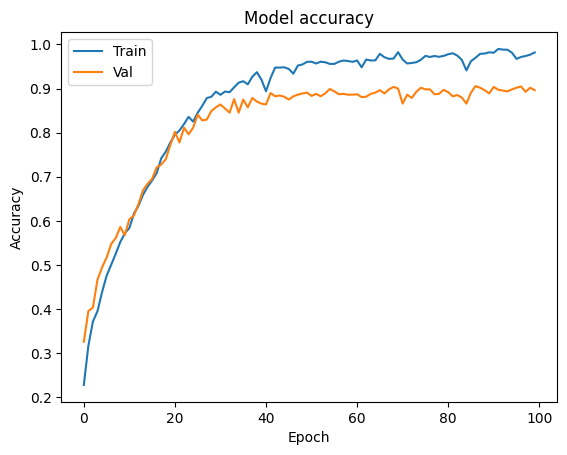

In [155]:
#plotting the resuts

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

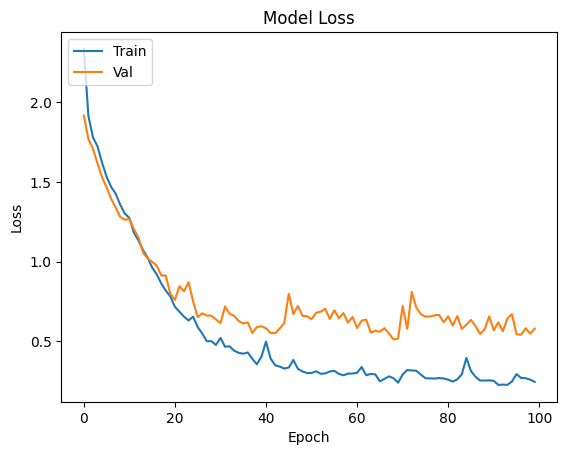

In [156]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [170]:
y_pred = model.predict(XTestProcessed)
y_pred_labels = np.argmax(y_pred, axis=-1)

34/34 [==============================] - 1s 33ms/step


<Axes: >

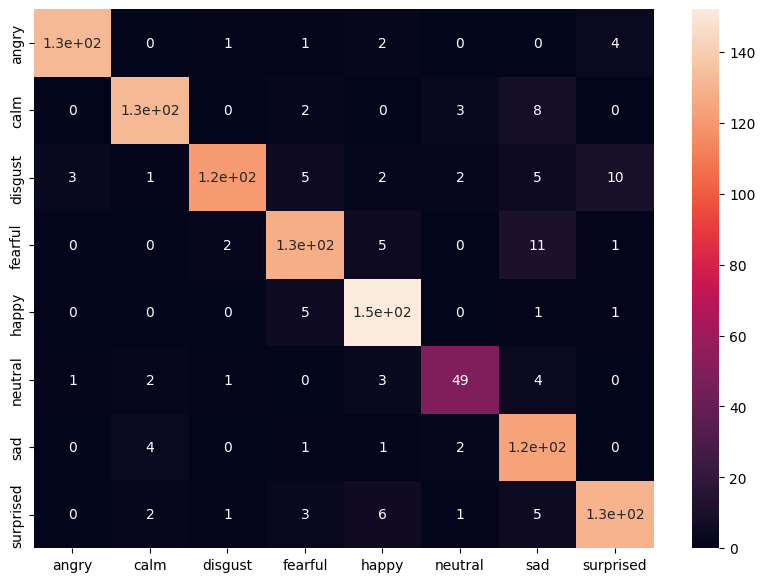

In [171]:
confusion_emotions = ['angry', 'calm', 'disgust', 'fearful','happy','neutral','sad','surprised']
cm=metrics.confusion_matrix(y_test,np.argmax(y_pred,axis=-1))
df_cm=pd.DataFrame(cm,index=[i for i in confusion_emotions],columns=[i for i in confusion_emotions])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm,annot=True)


In [172]:
#F1 score of the model
f1_score(y_test,np.argmax(y_pred,axis=-1),average='weighted')

0.8965297773560236

In [173]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(XTestProcessed, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

34/34 [==============================] - 1s 34ms/step - loss: 0.5806 - accuracy: 0.8963
Test Loss: 0.580634593963623
Test Accuracy: 0.8962963223457336


In [174]:
from sklearn.metrics import precision_score

precision = precision_score(y_test, y_pred_labels, average='weighted')
print(f'Precision: {precision:.4f}')

Precision: 0.9007


In [175]:
from sklearn.metrics import recall_score

recall = recall_score(y_test, y_pred_labels, average='weighted')
print(f'Recall: {recall:.4f}')

Recall: 0.8963


In [177]:
# Load the model from disk
loaded_model = load_model("models/cnn.h5")

In [178]:
# Load the data and extract features for each sound file
def load_single_data(file):
    x, y = [], []
    file_name = os.path.basename(file)
    emotion = emotions[file_name.split("-")[2]]
    data, sr = librosa.load(file)
    feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
    x.append(feature)
    y.append(emotion)
    return np.array(x), y

In [204]:
XX, yy = load_single_data("C:\\Users\\ARNAV_MISHRA\\OneDrive\\Desktop\\SpeechProject\\DataBase\\Actor_01\\03-01-05-02-02-02-01.wav")


In [205]:
yy

['angry']

In [206]:
# Load a single audio file using your load_single_data function
XX, yy = load_single_data("C:\\Users\\ARNAV_MISHRA\\OneDrive\\Desktop\\SpeechProject\\DataBase\\Actor_01\\03-01-05-02-02-02-01.wav")

# If needed, reshape XX to match the input shape expected by your model
XXTemp = np.expand_dims(XX, axis=2)  # Assuming your model expects a 3D input (samples, features, channels)

# Predict using your loaded model
predictions = model.predict(XXTemp)

# Assuming your model predicts probabilities for each class, you might want to get the class with the highest probability
predicted_class = np.argmax(predictions)

# Print or use the predicted class
print("Predicted class:", predicted_class)


1/1 [==============================] - 0s 48ms/step
Predicted class: 0


In [207]:
list(y_pred)

[array([1.7449536e-10, 1.5113055e-12, 2.8509260e-07, 9.9999511e-01,
        3.7895482e-09, 4.5320600e-10, 4.5681204e-06, 3.0977468e-08],
       dtype=float32),
 array([1.00000000e+00, 2.12596413e-10, 9.78975026e-11, 1.05110094e-13,
        2.09495843e-09, 9.45163114e-11, 3.31450070e-15, 9.35434574e-09],
       dtype=float32),
 array([7.0893776e-08, 4.7886786e-03, 9.9519795e-01, 1.0184489e-07,
        3.2589214e-09, 3.2658175e-08, 1.0223172e-05, 2.9868593e-06],
       dtype=float32),
 array([3.0512382e-08, 5.4366898e-05, 9.9874240e-01, 3.6037026e-04,
        6.1632300e-06, 8.8693093e-07, 6.9883981e-06, 8.2874246e-04],
       dtype=float32),
 array([9.7099401e-05, 2.4407436e-04, 1.3004257e-03, 3.2407575e-06,
        8.8199900e-05, 9.9780732e-01, 2.6422032e-04, 1.9540347e-04],
       dtype=float32),
 array([6.3787439e-07, 6.0304012e-10, 3.3218253e-08, 6.7116410e-08,
        8.0304053e-05, 3.2642429e-08, 3.0316663e-08, 9.9991882e-01],
       dtype=float32),
 array([1.8594999e-09, 9.9990892

In [208]:
# Reshape x_test to match the input shape expected by your model
x_test_reshaped = np.expand_dims(x_test, axis=2)  # Assuming your model expects a 3D input

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test_reshaped, y_test)

print("Overall accuracy on the test set:", accuracy)

34/34 [==============================] - 1s 32ms/step - loss: 0.5806 - accuracy: 0.8963
Overall accuracy on the test set: 0.8962963223457336


In [212]:
# Combine the training and test sets
X_full = np.concatenate((x_train, x_test), axis=0)
y_full = np.concatenate((y_train, y_test), axis=0)

# Ensure the data shape is correct for the full dataset
X_full_expanded = np.expand_dims(X_full, axis=2)

# Evaluate the model on the full dataset
loss, accuracy = model.evaluate(X_full_expanded, y_full)

# Prediction on the full dataset
y_pred = model.predict(X_full_expanded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculating precision, recall, and F1-score
precision = precision_score(y_full, y_pred_classes, average='weighted')
recall = recall_score(y_full, y_pred_classes, average='weighted')
f1 = f1_score(y_full, y_pred_classes, average='weighted')

# Print all metrics
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


135/135 [==============================] - 4s 31ms/step
Loss: 0.29301199316978455
Accuracy: 0.9736111164093018
Precision: 0.9739489543608643
Recall: 0.9736111111111111
F1-score: 0.9736338592098436
